## Problem Statement

#### Demand forecasts are fundamental to plan and deliver products and services. Accurate forecasting of demand can help the manufacturers to maintain appropriate stock which results in reduction in loss due to product not being sold and also reduces the opportunity cost (i.e. higher demand but less availability => opportunity lost). Despite such relevance, manufacturers have difficulty choosing which forecast model is the best for their use case. In this project, historical sales data corresponding to multiple(25) items sold in 10 stores are provided and participants are expected to come up with a best model to predict the future demand for products which results in maximum profit for the manufacturer. Predict the demand for the next 3 months at the item level (i.e. all the stores combined).


## Minimum Requirements

#### The end objective of the participant is to produce a model that gives the best prediction to the manufacturer. Such a model must include the seasonality of the items sold. 

In [ ]:
#Importing required libraries
import time
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import io, base64, os, json, re, glob
import datetime
from datetime import timedelta
import pandas as pd
import numpy as np
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Reading data from cdv file to dataframe
data= pd.read_csv('train 2.csv', 
                     low_memory=False, 
                     parse_dates=['date'], 
                     index_col=['date'])


In [ ]:
data.head()

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


In [ ]:
data.shape

(913000, 3)

In [ ]:
data.columns

Index(['store', 'item', 'sales'], dtype='object')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   store   913000 non-null  int64
 1   item    913000 non-null  int64
 2   sales   913000 non-null  int64
dtypes: int64(3)
memory usage: 27.9 MB


In [ ]:
data.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [ ]:
#Cheching if any null values in any column
data.isnull().sum()

store    0
item     0
sales    0
dtype: int64

In [ ]:
#getting uniue counts for all columns
data.nunique()

store     10
item      50
sales    213
dtype: int64

In [ ]:
data['item'].value_counts()

1     18260
38    18260
28    18260
29    18260
30    18260
31    18260
32    18260
33    18260
34    18260
35    18260
36    18260
37    18260
39    18260
2     18260
40    18260
41    18260
42    18260
43    18260
44    18260
45    18260
46    18260
47    18260
48    18260
49    18260
27    18260
26    18260
25    18260
24    18260
3     18260
4     18260
5     18260
6     18260
7     18260
8     18260
9     18260
10    18260
11    18260
12    18260
13    18260
14    18260
15    18260
16    18260
17    18260
18    18260
19    18260
20    18260
21    18260
22    18260
23    18260
50    18260
Name: item, dtype: int64

In [ ]:
# Sorting data by date in ascending order
data = data.sort_values('date', ascending=True)
data.head(10)

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-01,7,12,26
2013-01-01,7,46,27
2013-01-01,8,12,54
2013-01-01,9,12,35
2013-01-01,10,12,41
2013-01-01,6,46,23
2013-01-01,1,13,37
2013-01-01,2,13,51


In [ ]:
print("There are totally",data['item'].nunique(),"Unique Items.")

There are totally 50 Unique Items.


In [ ]:
# For each day finding sum of sales per item
data=data.groupby(['item','date'])['sales'].sum().reset_index()



In [ ]:
data.head()

,item,date,sales
0,1,2013-01-01,133
1,1,2013-01-02,99
2,1,2013-01-03,127
3,1,2013-01-04,145
4,1,2013-01-05,149


In [ ]:
# Rolling sum of sales for 3 months per date per item
datas=[]
for i in data.item.unique():
    tmp=data.loc[data.item==i,:]
    tmp['sales']=tmp['sales'].rolling(90).sum().shift(-89)
    datas.append(tmp)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
# dropping null values
for i in range(len(datas)):
    datas[i]=datas[i].dropna(axis=0)

Enter the item number to view sales of each item : 4


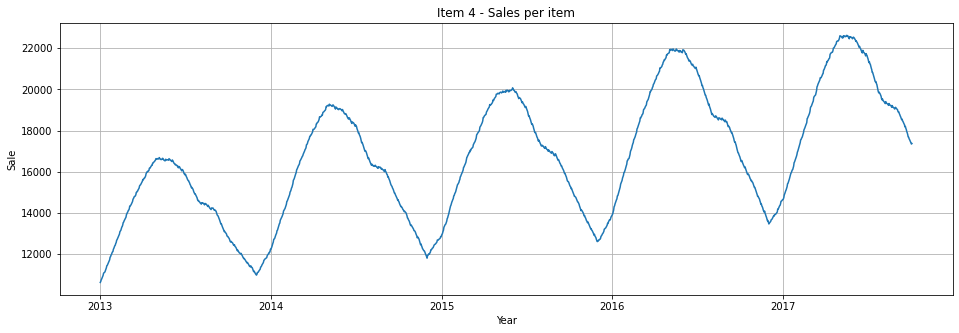

In [ ]:
# To view insights of items sale in each store

def plot_item(df_raw,i):
    plt.subplots(figsize = (16, 5))
    plt.grid()
    plt.xlabel("Year")
    plt.ylabel("Sale")
    plt.title('Item '+str(i)+' - Sales per item')
    plt.plot(df_raw['date'],df_raw['sales'])

#for i in range(1,df_raw['item'].nunique()+1):

item_input=int(input("Enter the item number to view sales of each item : "))
plot_item(datas[item_input],item_input)

In [ ]:

# Date Features
def create_date_features(datas):
    for i in range(len(datas)):
        datas[i]['year'] = datas[i].date.dt.year
        datas[i]['day_of_year'] = datas[i].date.dt.dayofyear
        datas[i]['month'] = datas[i].date.dt.month
        datas[i]['day_of_month'] = datas[i].date.dt.day
        datas[i]['week'] = datas[i].date.dt.weekofyear
        datas[i]['day_of_week'] = datas[i].date.dt.dayofweek
        datas[i]["is_wknd"] = datas[i].date.dt.weekday //5
        datas[i]['is_month_start'] = datas[i].date.dt.is_month_start.astype(int)
        datas[i]['is_month_end'] = datas[i].date.dt.is_month_end.astype(int)
    return datas

datas = create_date_features(datas)
#datas[0].head(10)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: Set

,item,date,sales,year,day_of_year,month,day_of_month,week,day_of_week,is_wknd,is_month_start,is_month_end
0,1,2013-01-01,12847.0,2013,1,1,1,1,1,0,1,0
1,1,2013-01-02,12848.0,2013,2,1,2,1,2,0,0,0
2,1,2013-01-03,12936.0,2013,3,1,3,1,3,0,0,0
3,1,2013-01-04,13019.0,2013,4,1,4,1,4,0,0,0
4,1,2013-01-05,13103.0,2013,5,1,5,1,5,1,0,0
5,1,2013-01-06,13153.0,2013,6,1,6,1,6,1,0,0
6,1,2013-01-07,13223.0,2013,7,1,7,2,0,0,0,0
7,1,2013-01-08,13375.0,2013,8,1,8,2,1,0,0,0
8,1,2013-01-09,13423.0,2013,9,1,9,2,2,0,0,0
9,1,2013-01-10,13458.0,2013,10,1,10,2,3,0,0,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


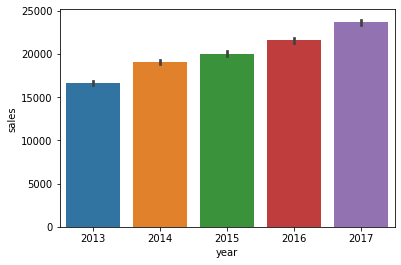

In [ ]:
# sales per year
sns.barplot(datas[0]['year'],datas[0]['sales'])

#### Above graph implements that there is frequesnt increse in sales each year

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


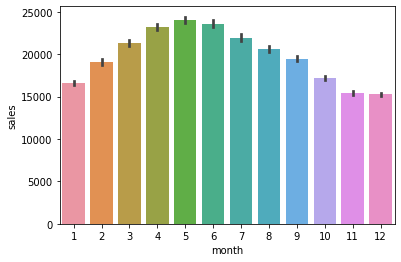

In [ ]:
# Sales per month
sns.barplot(datas[0]['month'],datas[0]['sales'])

#### From the above graph its clearly visible that the sales are maximum in middle of year

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


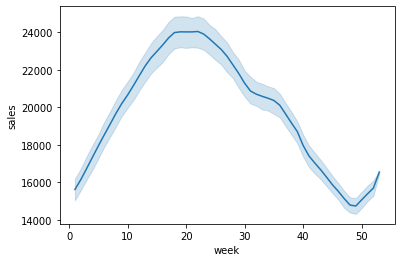

In [ ]:
# Sales per week
sns.lineplot(datas[0]['week'],datas[0]['sales'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


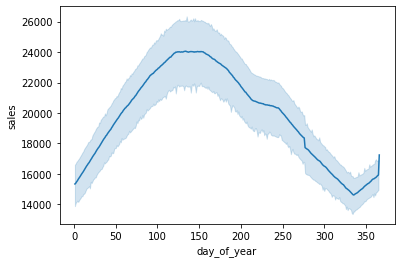

In [ ]:
# Sales per day of year
sns.lineplot(datas[0]['day_of_year'],datas[0]['sales'])

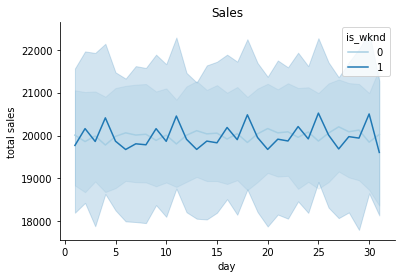

In [ ]:
# Set the color palette
sns.set_palette(sns.color_palette("Paired"))
# Plot the data, specifying a different color for data points in
# each of the day categories (weekday and weekend)
ax = sns.lineplot(x='day_of_month', y='sales', data=datas[0], hue='is_wknd')
# Customize the axes and title
ax.set_title("Sales")
ax.set_xlabel("day")
ax.set_ylabel("total sales")
# Remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

### ML modeling

In [ ]:
# Importing sklearn modules for training and testing
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
x=datas[0][['date']].values.astype('object')
y=datas[0]['sales']
x_train, x_test, y_train, y_test =train_test_split(x,y,test_size=0.40,random_state=21)
print('Shape of Training Xs:{}'.format(x_train.shape))
print('Shape of Test Xs:{}'.format(x_test.shape))
print('Shape of Training y:{}'.format(y_train.shape))
print('Shape of Test y:{}'.format(y_test.shape))

Shape of Training Xs:(1042, 1)
Shape of Test Xs:(695, 1)
Shape of Training y:(1042,)
Shape of Test y:(695,)


In [ ]:
y_train.isnull().sum()

0

### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(random_state=0)
classifier.fit(x_train, y_train)

y_pred = classifier.predict(x_test)



In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test[0:278], y_pred[0:278])

0.9995439796685444

In [ ]:
x_train1, x_test1, y_train1, y_test1 =train_test_split(x_train,y_train,test_size=0.20,random_state=60)
print('Shape of Training Xs:{}'.format(x_train1.shape))
print('Shape of Test Xs:{}'.format(x_test1.shape))
print('Shape of Training y:{}'.format(y_train1.shape))
print('Shape of Test y:{}'.format(y_test1.shape))

classifier = DecisionTreeClassifier()
classifier.fit(x, y)
y_pred = classifier.predict(x_test1)
y_pred



Shape of Training Xs:(833, 1)
Shape of Test Xs:(209, 1)
Shape of Training y:(833,)
Shape of Test y:(209,)


array([16050., 19954., 19139., 19061., 13724., 26843., 20590., 13375.,
       14943., 24159., 21047., 23206., 14817., 19730., 21803., 18924.,
       13912., 15240., 19509., 23057., 15263., 23629., 16445., 13984.,
       23067., 16781., 18298., 19316., 18215., 13322., 20954., 16490.,
       23388., 13202., 22725., 14573., 15731., 23889., 22991., 14392.,
       15201., 17408., 19904., 25494., 20939., 26930., 15188., 15474.,
       17771., 20860., 17019., 21757., 16428., 26628., 13236., 19508.,
       17562., 16970., 18020., 18126., 13103., 21425., 16710., 13964.,
       22764., 19261., 21900., 21338., 14576., 17020., 16637., 23019.,
       19812., 25848., 15820., 19782., 24218., 24096., 15614., 18897.,
       13663., 22640., 17164., 22899., 21768., 26084., 23091., 22869.,
       17731., 18146., 24610., 22712., 14833., 16273., 24174., 16269.,
       19741., 24116., 22199., 22690., 19864., 18808., 18824., 21780.,
       19075., 18287., 20562., 20808., 23096., 12936., 19522., 20826.,
      

In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test1[0:278], y_pred[0:278])

1.0

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=10,criterion="entropy")
classifier.fit(x_train, y_train)

y_pred = classifier.predict(x_test)



In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test[0:278], y_pred[0:278])

0.9995395898622776

In [ ]:
x_train1, x_test1, y_train1, y_test1 =train_test_split(x_train,y_train,test_size=0.30,random_state=60)
print('Shape of Training Xs:{}'.format(x_train1.shape))
print('Shape of Test Xs:{}'.format(x_test1.shape))
print('Shape of Training y:{}'.format(y_train1.shape))
print('Shape of Test y:{}'.format(y_test1.shape))

classifier = DecisionTreeClassifier()
classifier.fit(x, y)
y_pred = classifier.predict(x_test1)
y_pred



Shape of Training Xs:(729, 1)
Shape of Test Xs:(313, 1)
Shape of Training y:(729,)
Shape of Test y:(313,)


array([16050., 19954., 19139., 19061., 13724., 26843., 20590., 13375.,
       14943., 24159., 21047., 23206., 14817., 19730., 21803., 18924.,
       13912., 15240., 19509., 23057., 15263., 23629., 16445., 13984.,
       23067., 16781., 18298., 19316., 18215., 13322., 20954., 16490.,
       23388., 13202., 22725., 14573., 15731., 23889., 22991., 14392.,
       15201., 17408., 19904., 25494., 20939., 26930., 15188., 15474.,
       17771., 20860., 17019., 21757., 16428., 26628., 13236., 19508.,
       17562., 16970., 18020., 18126., 13103., 21425., 16710., 13964.,
       22764., 19261., 21900., 21338., 14576., 17020., 16637., 23019.,
       19812., 25848., 15820., 19782., 24218., 24096., 15614., 18897.,
       13663., 22640., 17164., 22899., 21768., 26084., 23091., 22869.,
       17731., 18146., 24610., 22712., 14833., 16273., 24174., 16269.,
       19741., 24116., 22199., 22690., 19864., 18808., 18824., 21780.,
       19075., 18287., 20562., 20808., 23096., 12936., 19522., 20826.,
      

In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test1[0:278], y_pred[0:278])

1.0

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5,metric="minkowski",p=2)
knn.fit(x_train, y_train)

y_pred = knn.predict(x_test)



In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test[0:278], y_pred[0:278])

0.9968935023439971

In [ ]:
x_train1, x_test1, y_train1, y_test1 =train_test_split(x_train,y_train,test_size=0.10,random_state=60)
print('Shape of Training Xs:{}'.format(x_train1.shape))
print('Shape of Test Xs:{}'.format(x_test1.shape))
print('Shape of Training y:{}'.format(y_train1.shape))
print('Shape of Test y:{}'.format(y_test1.shape))

classifier = DecisionTreeClassifier()
classifier.fit(x, y)
y_pred = classifier.predict(x_test1)
y_pred



Shape of Training Xs:(937, 1)
Shape of Test Xs:(105, 1)
Shape of Training y:(937,)
Shape of Test y:(105,)


array([16050., 19954., 19139., 19061., 13724., 26843., 20590., 13375.,
       14943., 24159., 21047., 23206., 14817., 19730., 21803., 18924.,
       13912., 15240., 19509., 23057., 15263., 23629., 16445., 13984.,
       23067., 16781., 18298., 19316., 18215., 13322., 20954., 16490.,
       23388., 13202., 22725., 14573., 15731., 23889., 22991., 14392.,
       15201., 17408., 19904., 25494., 20939., 26930., 15188., 15474.,
       17771., 20860., 17019., 21757., 16428., 26628., 13236., 19508.,
       17562., 16970., 18020., 18126., 13103., 21425., 16710., 13964.,
       22764., 19261., 21900., 21338., 14576., 17020., 16637., 23019.,
       19812., 25848., 15820., 19782., 24218., 24096., 15614., 18897.,
       13663., 22640., 17164., 22899., 21768., 26084., 23091., 22869.,
       17731., 18146., 24610., 22712., 14833., 16273., 24174., 16269.,
       19741., 24116., 22199., 22690., 19864., 18808., 18824., 21780.,
       19075.])

In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test1[0:278], y_pred[0:278])

1.0

## Conclusions and Recommendations 

#### Forecasting future demands is a challenge that companies have to face in order to be able to make decisions that allow them to compete by generating better supply chain results. Demand forecasting is an essential activity for business planning, as it results in several benefits, such as: reduced waste, better allocation of resources, increased sales and revenue. This way, it helps organizations to be in the right place, at the right time, with the right product.